In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('./data/all_games.csv')

In [4]:
data.shape

(66080, 67)

In [6]:
data.head()

,Unnamed: 0,timestamp,date_GMT,status,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_goal_timings,away_team_goal_timings,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name
0,0,1249669800,Aug 07 2009 - 6:30pm,complete,NaN,Wolfsburg,Stuttgart,Felix Brych,1.0,0.0,0.0,1.35,1.53,2,0,2,0,0,0,"71,82",NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,VOLKSWAGEN ARENA (Wolfsburg)
1,1,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Borussia Dortmund,Köln,Wolfgang Stark,1.0,0.0,0.0,2.00,1.35,1,0,1,0,0,0,75,NaN,-1,-1,0,0,1,0,0,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Signal-Iduna-Park (Dortmund)
2,2,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Nürnberg,Schalke 04,Knut Kircher,1.0,0.0,0.0,1.12,1.76,1,2,3,1,0,1,88,"36,50",-1,-1,2,0,1,0,1,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Max-Morlock-Stadion (Nürnberg)
3,3,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Werder Bremen,Eintracht Frankfurt,NaN,1.0,0.0,0.0,1.76,1.18,2,3,5,4,2,2,"13,44","6,42,71",-1,-1,2,1,2,0,1,2,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wohninvest WESERSTADION (Bremen)
4,4,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Hertha BSC,Hannover 96,Guido Winkmann,1.0,0.0,0.0,0.53,0.82,1,0,1,0,0,0,82,NaN,-1,-1,3,0,2,0,0,3,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Olympiastadion Berlin (Berlin)


In [ ]:
"""
metoda clean data

do dropnięcia: Unnamed: 0, timestamp, status, home_team_goal_timings, away_team_goal_timings
do dropnięcia mecze anulowane
zmienna o tym czy mecz był rozgrywany na stadionie gospodarza czy nie
"""

In [17]:
def clean_data(data):
    #transforming date variable
    data['date_GMT'] = pd.to_datetime(data['date_GMT'])
    data['date'] = pd.to_datetime(data['date_GMT'].dt.date)
    data['time'] = data['date_GMT'].dt.time
    
    #adding aggregated variables
    data['corners_total'] = data['home_team_corner_count'] + data['away_team_corner_count']
    data['yellow_cards_total'] = data['home_team_yellow_cards'] + data['away_team_yellow_cards']
    data['red_cards_total'] = data['home_team_red_cards'] + data['away_team_red_cards']
    data['cards_total'] = data['yellow_cards_total'] + data['red_cards_total']
    data['shots_total'] = data['home_team_shots'] + data['away_team_shots']
    data['shots_on_target_total'] = data['home_team_shots_on_target'] + data['away_team_shots_on_target']
    data['shots_off_target_total'] = data['home_team_shots_off_target'] + data['away_team_shots_off_target']
    data['fouls_total'] = data['home_team_fouls'] + data['away_team_fouls']
    
    #getting stadium names without city in brackets
    # data['base_name'] = data['stadium_name'].str.replace(r" \(.*\)$", "", regex=True)

    # city_map = data[data['stadium_name'].str.contains(r"\(.*\)")].copy()
    # city_map['city'] = city_map['stadium_name'].str.extract(r"\((.*?)\)")[0]
    # city_map = city_map.groupby('base_name')['city'].agg(pd.Series.mode).to_dict()

    # #filling stadium names without city in brackets
    # data['normalized_stadium'] = data.apply(lambda row: f"{row['base_name']} ({city_map.get(row['base_name'], 'Unknown')})" if '(' not in row['stadium_name'] else row['stadium_name'], axis=1)

    #dropping unnecessary features
    data.drop(['Unnamed: 0', 'timestamp', 'status', 'home_team_goal_timings', 'away_team_goal_timings', 'date_GMT'], axis=1, inplace=True)
    
    #setting one of the target variable - result of the game
    data['result'] = np.where(data['home_team_goal_count'] == data['away_team_goal_count'], 0, np.where(data['home_team_goal_count'] > data['away_team_goal_count'], 1, 2))
    
    def assign_season(date):
        year = date.year
        if date.month >= 8:  # Sezon zaczyna się w sierpniu
            return f'{str(year)[2:]}/{str(year+1)[2:]}'
        else:
            return f'{str(year-1)[2:]}/{str(year)[2:]}'
    
    data['season'] = data['date'].apply(assign_season)
    
    return data

In [18]:
data = clean_data(data)

In [19]:
data.isna().sum()

attendance                             21359
home_team_name                             0
away_team_name                             0
referee                                24472
Game Week                               8325
Pre-Match PPG (Home)                       0
Pre-Match PPG (Away)                       0
home_ppg                                   0
away_ppg                                   0
home_team_goal_count                       0
away_team_goal_count                       0
total_goal_count                           0
total_goals_at_half_time                   0
home_team_goal_count_half_time             0
away_team_goal_count_half_time             0
home_team_corner_count                     0
away_team_corner_count                     0
home_team_yellow_cards                     0
home_team_red_cards                        0
away_team_yellow_cards                     0
away_team_red_cards                        0
home_team_first_half_cards                 0
home_team_

In [17]:
data[data['stadium_name'].isna()]['home_team_name'].value_counts(normalize=True)

home_team_name
Burnley                    0.025025
Reading                    0.024024
Sheffield United           0.024024
Birmingham City            0.023023
Wolverhampton Wanderers    0.023023
                             ...   
Vllaznia Shkodër           0.001001
Gomel                      0.001001
Struga                     0.001001
Wolfsberger AC             0.001001
St. Johnstone              0.001001
Name: proportion, Length: 177, dtype: float64

In [16]:
data['home_team_name'].nunique()

892

In [14]:
data[data['home_team_name'] == 'Raków Częstochowa']['stadium_name']

18946                        Stadion GKS-u (Bełchatów)
18962                        Stadion GKS-u (Bełchatów)
18981                      Stadion Raków (Częstochowa)
18986                        Stadion GKS-u (Bełchatów)
19001                        Stadion GKS-u (Bełchatów)
19017                        Stadion GKS-u (Bełchatów)
19039                        Stadion GKS-u (Bełchatów)
19055                        Stadion GKS-u (Bełchatów)
19077                        Stadion GKS-u (Bełchatów)
19090                        Stadion GKS-u (Bełchatów)
19116                        Stadion GKS-u (Bełchatów)
19128                        Stadion GKS-u (Bełchatów)
19148                        Stadion GKS-u (Bełchatów)
19165                        Stadion GKS-u (Bełchatów)
19182                        Stadion GKS-u (Bełchatów)
19188                        Stadion GKS-u (Bełchatów)
19200                        Stadion GKS-u (Bełchatów)
19210                        Stadion GKS-u (Bełchatów)
19234     

In [23]:
# Wyodrębnienie nazw stadionów bez miasta
data['base_name'] = data['stadium_name'].str.replace(r" \(.*\)$", "", regex=True)

# Tworzenie mapy nazw z najczęściej występującym miastem w nawiasie dla każdego stadionu
city_map = data[data['stadium_name'].str.contains(r"\(.*\)")].copy()
city_map['city'] = city_map['stadium_name'].str.extract(r"\((.*?)\)")[0]
city_map = city_map.groupby('base_name')['city'].agg(pd.Series.mode).to_dict()

# Uzupełnianie miast dla nazw stadionów bez nawiasów
data['normalized_stadium'] = data.apply(lambda row: f"{row['base_name']} ({city_map.get(row['base_name'], 'Unknown')})" if '(' not in row['stadium_name'] else row['stadium_name'], axis=1)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [22]:
for team in data[data['stadium_name'].isna()]['home_team_name'].unique():
    print(data[data['home_team_name'] == team]['stadium_name'].value_counts(normalize=True, dropna=False))
    print('-----')

stadium_name
St Andrew's Trillion Trophy Stadium (Birmingham)    0.518006
St. Andrew's Stadium                                0.310249
St Andrew's Stadium (Birmingham)                    0.108033
NaN                                                 0.063712
Name: proportion, dtype: float64
-----
stadium_name
Kiyan Prince Foundation Stadium (London)    0.479042
Loftus Road Stadium                         0.383234
NaN                                         0.068862
Loftus Road (London)                        0.068862
Name: proportion, dtype: float64
-----
stadium_name
NaN                     0.5
Home Park (Plymouth)    0.5
Name: proportion, dtype: float64
-----
stadium_name
Portman Road (Ipswich- Suffolk)    0.460630
Portman Road Stadium               0.448819
NaN                                0.090551
Name: proportion, dtype: float64
-----
stadium_name
Pride Park Stadium (Derby)    0.598266
iPro Stadium (Derby)          0.315029
NaN                           0.066474
Pride Park Stadium

In [11]:
data['status'].value_counts(normalize=True)

status
complete    0.99655
canceled    0.00345
Name: proportion, dtype: float64

In [12]:
data['stadium_name'].value_counts()

stadium_name
Stadio Giuseppe Meazza (Milano)                  420
Stadio Olimpico (Roma)                           410
The City Ground (Nottingham- Nottinghamshire)    321
St. James' Park (Newcastle upon Tyne)            319
Stadio Comunale Luigi Ferraris (Genova)          311
                                                ... 
Batumi Arena (Adjarabet Arena) (Batumi)            1
Við Djúpumýrar (Klaksvík- Borðoy)                  1
Yeni Sakarya Atatürk Stadyumu (Adapazarı)          1
DG Arena (Podgorica)                               1
Park Avenue (Aberystwyth- Ceredigion)              1
Name: count, Length: 1499, dtype: int64

In [15]:
data[data['home_team_name'] == 'Rangers']['stadium_name'].value_counts(dropna=False)

stadium_name
Ibrox Stadium (Glasgow)    112
Ibrox Stadium               63
NaN                          3
Name: count, dtype: int64

In [16]:
data['home_team_name'].nunique()

892

In [ ]:
data[(data['home_team_name'] == 'Rangers') & (data['stadium_name'] == )]

# Daty

In [24]:
data['date_GMT'] = pd.to_datetime(data['date_GMT'])
data['date'] = pd.to_datetime(data['date_GMT'].dt.date)
data['time'] = data['date_GMT'].dt.time

In [25]:
data.drop('date_GMT', axis=1, inplace=True)

In [26]:
data.head()

,Unnamed: 0,timestamp,status,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_goal_timings,away_team_goal_timings,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name,date,time,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,base_name
0,0,1249669800,complete,NaN,Wolfsburg,Stuttgart,Felix Brych,1.0,0.0,0.0,1.35,1.53,2,0,2,0,0,0,"71,82",NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,VOLKSWAGEN ARENA (Wolfsburg),2009-08-07,18:30:00,-2,-2,-2,-4,-2,-2,-2,-2,VOLKSWAGEN ARENA
1,1,1249738200,complete,NaN,Borussia Dortmund,Köln,Wolfgang Stark,1.0,0.0,0.0,2.00,1.35,1,0,1,0,0,0,75,NaN,-1,-1,0,0,1,0,0,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Signal-Iduna-Park (Dortmund),2009-08-08,13:30:00,-2,1,0,1,-2,-2,-2,-2,Signal-Iduna-Park
2,2,1249738200,complete,NaN,Nürnberg,Schalke 04,Knut Kircher,1.0,0.0,0.0,1.12,1.76,1,2,3,1,0,1,88,"36,50",-1,-1,2,0,1,0,1,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Max-Morlock-Stadion (Nürnberg),2009-08-08,13:30:00,-2,3,0,3,-2,-2,-2,-2,Max-Morlock-Stadion
3,3,1249738200,complete,NaN,Werder Bremen,Eintracht Frankfurt,NaN,1.0,0.0,0.0,1.76,1.18,2,3,5,4,2,2,"13,44","6,42,71",-1,-1,2,1,2,0,1,2,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wohninvest WESERSTADION (Bremen),2009-08-08,13:30:00,-2,4,1,5,-2,-2,-2,-2,wohninvest WESERSTADION
4,4,1249738200,complete,NaN,Hertha BSC,Hannover 96,Guido Winkmann,1.0,0.0,0.0,0.53,0.82,1,0,1,0,0,0,82,NaN,-1,-1,3,0,2,0,0,3,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Olympiastadion Berlin (Berlin),2009-08-08,13:30:00,-2,5,0,5,-2,-2,-2,-2,Olympiastadion Berlin


In [27]:
data.dtypes

Unnamed: 0                                      int64
timestamp                                       int64
status                                         object
attendance                                    float64
home_team_name                                 object
away_team_name                                 object
referee                                        object
Game Week                                     float64
Pre-Match PPG (Home)                          float64
Pre-Match PPG (Away)                          float64
home_ppg                                      float64
away_ppg                                      float64
home_team_goal_count                            int64
away_team_goal_count                            int64
total_goal_count                                int64
total_goals_at_half_time                        int64
home_team_goal_count_half_time                  int64
away_team_goal_count_half_time                  int64
home_team_goal_timings      

## Zmienna - sezon

In [7]:
def assign_season(date):
    year = date.year
    if date.month >= 8:  # Sezon zaczyna się w sierpniu
        return f'{str(year)[2:]}/{str(year+1)[2:]}'
    else:
        return f'{str(year-1)[2:]}/{str(year)[2:]}'

In [8]:
data['season'] = data['date'].apply(assign_season)

In [9]:
data.sort_values(by='date')

,Unnamed: 0,timestamp,date_GMT,status,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_goal_timings,away_team_goal_timings,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name,date,time,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,base_name,season
48683,48683,1186832700,2007-08-11 11:45:00,complete,NaN,Sunderland,Tottenham Hotspur,NaN,NaN,0.00,0.00,1.58,0.89,1,0,1,0,0,0,90'3,NaN,-1,-1,1,0,1,0,0,1,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Stadium of Light (Sunderland),2007-08-11,11:45:00,-2,2,0,2,-2,-2,-2,-2,Stadium of Light,07/08
48689,48689,1186848900,2007-08-11 16:15:00,complete,NaN,Aston Villa,Liverpool,NaN,NaN,0.00,0.00,1.74,1.79,1,2,3,1,0,1,84,"30,87",-1,-1,4,0,2,0,1,3,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Villa Park (Birmingham),2007-08-11,16:15:00,-2,6,0,6,-2,-2,-2,-2,Villa Park,07/08
48688,48688,1186840800,2007-08-11 14:00:00,complete,NaN,Bolton Wanderers,Newcastle United,NaN,NaN,0.00,0.00,1.37,0.74,1,3,4,3,0,3,50,"11,21,26",-1,-1,1,0,1,0,0,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,University of Bolton Stadium (Bolton),2007-08-11,14:00:00,-2,2,0,2,-2,-2,-2,-2,University of Bolton Stadium,07/08
48684,48684,1186840800,2007-08-11 14:00:00,complete,NaN,West Ham United,Manchester City,NaN,NaN,0.00,0.00,1.47,0.95,0,2,2,1,0,1,NaN,"18,87",-1,-1,0,0,4,0,0,0,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Boleyn Ground (London),2007-08-11,14:00:00,-2,4,0,4,-2,-2,-2,-2,Boleyn Ground,07/08
48686,48686,1186840800,2007-08-11 14:00:00,complete,NaN,Everton,Wigan Athletic,NaN,NaN,0.00,0.00,1.95,0.58,2,1,3,1,1,0,"26,75",80,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Goodison Park (Liverpool),2007-08-11,14:00:00,-2,-2,-2,-4,-2,-2,-2,-2,Goodison Park,07/08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66078,66078,1686157200,2023-06-07 17:00:00,complete,NaN,Ankaragücü,Adana Demirspor,Çağdaş Altay,38.0,1.29,1.53,1.22,1.61,1,2,3,1,0,1,82,"31,57",7,1,0,0,0,0,0,0,0,0,13,9,8,6,5,3,13,9,51,49,1.65,1.82,1.96,1.40,3.00,68,88,

In [10]:
data.isna().sum()

Unnamed: 0                                 0
timestamp                                  0
date_GMT                                   0
status                                     0
attendance                             21359
home_team_name                             0
away_team_name                             0
referee                                24472
Game Week                               8325
Pre-Match PPG (Home)                       0
Pre-Match PPG (Away)                       0
home_ppg                                   0
away_ppg                                   0
home_team_goal_count                       0
away_team_goal_count                       0
total_goal_count                           0
total_goals_at_half_time                   0
home_team_goal_count_half_time             0
away_team_goal_count_half_time             0
home_team_goal_timings                 15583
away_team_goal_timings                 21901
home_team_corner_count                     0
away_team_

In [33]:
data_clean = data.dropna(subset=['stadium_name'])

In [35]:
data_clean.shape

(65081, 78)

In [37]:
data.isna().sum()

Unnamed: 0                                 0
timestamp                                  0
status                                     0
attendance                             21359
home_team_name                             0
away_team_name                             0
referee                                24472
Game Week                               8325
Pre-Match PPG (Home)                       0
Pre-Match PPG (Away)                       0
home_ppg                                   0
away_ppg                                   0
home_team_goal_count                       0
away_team_goal_count                       0
total_goal_count                           0
total_goals_at_half_time                   0
home_team_goal_count_half_time             0
away_team_goal_count_half_time             0
home_team_goal_timings                 15583
away_team_goal_timings                 21901
home_team_corner_count                     0
away_team_corner_count                     0
home_team_

In [39]:
data_clean.drop(['Unnamed: 0', 'timestamp', 'status', 'attendance', 'referee', 'Game Week', 'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_team_goal_timings', 'away_team_goal_timings',
                 'stadium_name', 'base_name'], axis=1, inplace=True)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5028\3156604440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.drop(['Unnamed: 0', 'timestamp', 'status', 'attendance', 'referee', 'Game Week', 'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_team_goal_timings', 'away_team_goal_timings',


In [42]:
data_clean.dtypes

home_team_name                                 object
away_team_name                                 object
home_ppg                                      float64
away_ppg                                      float64
home_team_goal_count                            int64
away_team_goal_count                            int64
total_goal_count                                int64
total_goals_at_half_time                        int64
home_team_goal_count_half_time                  int64
away_team_goal_count_half_time                  int64
home_team_corner_count                          int64
away_team_corner_count                          int64
home_team_yellow_cards                          int64
home_team_red_cards                             int64
away_team_yellow_cards                          int64
away_team_red_cards                             int64
home_team_first_half_cards                      int64
home_team_second_half_cards                     int64
away_team_first_half_cards  

In [41]:
data_clean['result'] = np.where(data_clean['home_team_goal_count'] == data_clean['away_team_goal_count'], 0, np.where(data_clean['home_team_goal_count'] > data_clean['away_team_goal_count'], 1, 2))

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5028\2921145499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['result'] = np.where(data_clean['home_team_goal_count'] == data_clean['away_team_goal_count'], 0, np.where(data_clean['home_team_goal_count'] > data_clean['away_team_goal_count'], 1, 2))


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FootballModel(nn.Module):
    def __init__(self, num_teams, embedding_dim, num_features):
        super(FootballModel, self).__init__()
        self.team_embeddings = nn.Embedding(num_teams, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2 + num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Liczba goli, może być zmodyfikowane dla innych wyników

    def forward(self, home_team, away_team, features):
        home_embed = self.team_embeddings(home_team)
        away_embed = self.team_embeddings(away_team)
        
        # Łączenie osadzeń drużyn z dodatkowymi cechami
        x = torch.cat((home_embed, away_embed, features), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [83]:
data_clean

,home_team_name,away_team_name,home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,date,time,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,season,result
0,Wolfsburg,Stuttgart,1.35,1.53,2,0,2,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2009-08-07,18:30:00,-2,-2,-2,-4,-2,-2,-2,-2,09/10,1
1,Borussia Dortmund,Köln,2.00,1.35,1,0,1,0,0,0,-1,-1,0,0,1,0,0,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2009-08-08,13:30:00,-2,1,0,1,-2,-2,-2,-2,09/10,1
2,Nürnberg,Schalke 04,1.12,1.76,1,2,3,1,0,1,-1,-1,2,0,1,0,1,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2009-08-08,13:30:00,-2,3,0,3,-2,-2,-2,-2,09/10,2
3,Werder Bremen,Eintracht Frankfurt,1.76,1.18,2,3,5,4,2,2,-1,-1,2,1,2,0,1,2,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2009-08-08,13:30:00,-2,4,1,5,-2,-2,-2,-2,09/10,2
4,Hertha BSC,Hannover 96,0.53,0.82,1,0,1,0,0,0,-1,-1,3,0,2,0,0,3,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2009-08-08,13:30:00,-2,5,0,5,-2,-2,-2,-2,09/10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66075,Fenerbahçe,Gazişehir Gaziantep,2.28,0.67,3,0,3,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2.06,1.42,0.00,0.00,3.45,47,85,68,36,27,33,68,47,83,11.07,5.64,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2023-06-07,13:00:00,-2,-2,-2,-4,-2,-2,-2,-2,22/23,1
66076,Giresunspor,Antalyaspor,1.22,0.78,2,0,2,1,1,0,3,11,2,1,1,0,1,2,1,0,6,17,4,6,2,11,13,12,31,69,1.80,1.29,0.91,2.09,2.77,50,71,44,33,21,35,65,41,74,9.56,4.93,2.00,3.40,3.1,1.20,1.53,2.33,4.40,1.60,2.39,2023-06-07,17:00:00,14,3,1,4,23,10,13,25,22/23,1
66077,İstanbulspor,Ümraniyespor,1.17,0.94,4,0,4,1,1,0,8,1,3,0,1,0,0,3,0,1,21,3,14,2,7,1,13,9,63,37,1.25,1.56,2.98,0.57,3.15,59,76,56,35,24,44,85,47,74,9.04,4.60,1.91,3.50,3.2,1.15,1.65,2.15,3.78,1.48,2.57,2023-06-07,17:00:00,9,4,0,4,24,16,8,22,22/23,1
66078,Ankaragücü,Adana Demirspor,1.22,1.61,1,2,3,1,0,1,7,1,0,0,0,0,0,0,0,0,13,9,8,6,5,3,13,9,51,49,1.65,1.82,1.96,1.40,3.00,68,88,59,32,27,35,71,62,88,10.30,4.35,2.30,3.50,2.5,1.10,1.73,1.95,3.15,1.39,3.11,2023-06-07,17:00:00,8,0,0,0,22,14,8,22,22/23,2


In [84]:
import pandas as pd

# Załóżmy, że 'data' to twój DataFrame
all_teams = pd.concat([data_clean['home_team_name'], data_clean['away_team_name']]).unique()
team_to_idx = {team: idx for idx, team in enumerate(all_teams)}

In [85]:
# Zamiana nazw drużyn na indeksy dla każdego meczu
data_clean['home_team_idx'] = data_clean['home_team_name'].map(team_to_idx)
data_clean['away_team_idx'] = data_clean['away_team_name'].map(team_to_idx)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5028\1234282150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['home_team_idx'] = data_clean['home_team_name'].map(team_to_idx)
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5028\1234282150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['away_team_idx'] = data_clean['away_team_name'].map(team_to_idx)


In [86]:
from sklearn.model_selection import train_test_split

# Lista kolumn do wykluczenia
exclude_columns = [
    'result', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 
    'home_team_name', 'away_team_name', 'date', 'time', 'season'
]

# Wybór kolumn, które są numeryczne i nie znajdują się na liście wykluczeń
features_columns = [col for col in data_clean.columns if data_clean[col].dtype in [np.float64, np.int64] and col not in exclude_columns]

# Przygotuj dane dla modelu
X = data_clean[features_columns]  # Dodaj inne cechy jako potrzebne
y = data_clean['result']  # Lub inna kolumna zależna od zadania

# Podział danych na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Załóżmy, że 'team_to_idx' to słownik mapujący nazwy drużyn na unikalne indeksy
home_teams = torch.tensor([team_to_idx[name] for name in data_clean['home_team_name']])
away_teams = torch.tensor([team_to_idx[name] for name in data_clean['away_team_name']])
import pandas as pd
import torch

# Lista kolumn do wykluczenia
exclude_columns = [
    'result', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 
    'home_team_name', 'away_team_name', 'date', 'time', 'season'
]

# Wybór kolumn, które są numeryczne i nie znajdują się na liście wykluczeń
features_columns = [col for col in data_clean.columns if data_clean[col].dtype in [np.float64, np.int64] and col not in exclude_columns]

# Tworzenie tensora z wybranych cech
features = torch.tensor(data_clean[features_columns].values.astype(np.float32))


In [57]:
data_clean.to_csv('./data/model_data.csv')

In [61]:
data_loader

In [62]:
model = FootballModel(num_teams=len(team_to_idx), embedding_dim=50, num_features=features.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Dla regresji liczby goli; użyj CrossEntropyLoss dla klasyfikacji wyniku

from torch.utils.data import DataLoader, TensorDataset

# Przygotowanie danych
dataset = TensorDataset(features, torch.tensor(data_clean['total_goal_count'].values, dtype=torch.float32))
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)  # Użyj mniejszego batch_size, jeśli jest taka potrzeba

# Pętla treningowa z użyciem DataLoader
# for epoch in range(100):
#     for batch in data_loader:
#         features_batch, targets_batch = batch
#         optimizer.zero_grad()
#         predictions = model(home_teams, away_teams, features_batch)
#         loss = criterion(predictions, targets_batch)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# W pętli treningowej, upewnij się, że przekazujesz tylko indeksy dla bieżącej partii
for epoch in range(100):  # Liczba epok
    for batch in data_loader:
        features_batch, targets_batch = batch
        optimizer.zero_grad()

        # Aktualizacja: Pobieranie indeksów drużyn dla bieżącej partii
        home_teams_batch = home_teams[batch.indices]  # Dostosuj, jeśli masz inną metodę indeksowania
        away_teams_batch = away_teams[batch.indices]

        # Wykonanie predykcji
        predictions = model(home_teams_batch, away_teams_batch, features_batch)

        # Obliczanie straty i wykonanie kroku optymalizacyjnego
        loss = criterion(predictions, targets_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


AttributeError: 'list' object has no attribute 'indices'

In [67]:
from torch.utils.data import DataLoader, TensorDataset

# Przygotowanie danych
dataset = TensorDataset(features, torch.tensor(data_clean['total_goal_count'].values, dtype=torch.float32))
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Pętla treningowa z manualnym śledzeniem indeksów
for epoch in range(100):
    for i, (features_batch, targets_batch) in enumerate(data_loader):
        batch_start = i * data_loader.batch_size
        batch_end = batch_start + features_batch.size(0)

        # Wyodrębnienie odpowiednich indeksów dla home_teams i away_teams
        home_teams_batch = home_teams[batch_start:batch_end]
        away_teams_batch = away_teams[batch_start:batch_end]

        optimizer.zero_grad()

        # Wykonanie predykcji
        predictions = model(home_teams_batch, away_teams_batch, features_batch)

        # Obliczanie straty i wykonanie kroku optymalizacyjnego
        loss = criterion(predictions, targets_batch)
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 2.2620880603790283
Epoch 6, Loss: 3.7621076107025146
Epoch 11, Loss: 1.7562406063079834
Epoch 16, Loss: 2.621856927871704
Epoch 21, Loss: 2.876157760620117
Epoch 26, Loss: 2.858184814453125
Epoch 31, Loss: 2.6403555870056152
Epoch 36, Loss: 3.475630521774292
Epoch 41, Loss: 3.6825263500213623
Epoch 46, Loss: 3.255009412765503
Epoch 51, Loss: 2.8816211223602295
Epoch 56, Loss: 3.0204551219940186
Epoch 61, Loss: 2.4734113216400146
Epoch 66, Loss: 2.022355318069458
Epoch 71, Loss: 2.740805149078369
Epoch 76, Loss: 3.154503107070923
Epoch 81, Loss: 3.3119187355041504
Epoch 86, Loss: 3.5286076068878174
Epoch 91, Loss: 3.0966293811798096
Epoch 96, Loss: 2.0056114196777344


In [71]:
from sklearn.model_selection import train_test_split

In [ ]:
features_columns = [col for col in data_clean.columns if data_clean[col].dtype in [np.float64, np.int64] and col not in exclude_columns]

In [77]:
X = data_clean[features_columns]
y = data_clean['total_goal_count']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [81]:
# Zakładam, że X_test, y_test są już przygotowane przez train_test_split i są w formie numpy array
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Stwórz TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Stwórz DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [82]:
# Zakładając, że masz zdefiniowany DataLoader dla danych testowych
test_loss = 0
num_batches = 0

model.eval()  # Przełącz model w tryb ewaluacji
with torch.no_grad():  # Wyłączenie obliczeń gradientów
    for features_batch, targets_batch in test_loader:
        predictions = model(home_teams_batch, away_teams_batch, features_batch)
        loss = criterion(predictions, targets_batch)
        test_loss += loss.item()
        num_batches += 1

average_test_loss = test_loss / num_batches
print(f'Average Test Loss: {average_test_loss}')


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 57 but got size 64 for tensor number 2 in the list.

In [27]:
from tensorflow.keras.layers import Flatten

class FootballMatchPredictor:
    def __init__(self, num_teams, embedding_dim=50, lstm_dim=64, dense_dim=64, dropout_rate=0.5):
        self.num_teams = num_teams
        self.embedding_dim = embedding_dim
        self.lstm_dim = lstm_dim
        self.dense_dim = dense_dim
        self.dropout_rate = dropout_rate
        self.model = self.build_model()

    def build_model(self):
        # Inputs
        home_input = Input(shape=(1,), dtype='int32', name='home_team_input')
        away_input = Input(shape=(1,), dtype='int32', name='away_team_input')
        match_stats_input = Input(shape=(10,), name='match_stats_input')  # Zaktualizowane: Brak wymiaru sekwencji

        # Embeddings and LSTM
        team_embedding = Embedding(input_dim=self.num_teams, output_dim=self.embedding_dim, input_length=1)
        home_embedded = team_embedding(home_input)
        away_embedded = team_embedding(away_input)

        # Flattening embedded outputs to remove the sequence dimension
        home_flatten = Flatten()(home_embedded)
        away_flatten = Flatten()(away_embedded)

        # Concatenate all features
        concatenated = concatenate([home_flatten, away_flatten, match_stats_input])

        # Dense layers
        x = Dense(self.dense_dim, activation='relu')(concatenated)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(self.dense_dim, activation='relu')(x)
        output = Dense(1, activation='sigmoid')(x)  # Example prediction: probability of home team winning

        # Build and compile the model
        model = Model(inputs=[home_input, away_input, match_stats_input], outputs=output)
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):
        return self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, verbose=0)

    def predict(self, X):
        return self.model.predict(X)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Załaduj dane
# data = pd.read_csv('path_to_your_data.csv')

# Kodowanie nazw drużyn
label_encoder = LabelEncoder()
data['home_team_name_label'] = label_encoder.fit_transform(data['home_team_name'])
data['away_team_name_label'] = label_encoder.fit_transform(data['away_team_name'])

In [22]:
data.head()

,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name,date,time,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,base_name,season,result,home_team_name_label,away_team_name_label
0,NaN,Wolfsburg,Stuttgart,Felix Brych,1.0,0.0,0.0,1.35,1.53,2,0,2,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,VOLKSWAGEN ARENA (Wolfsburg),2009-08-07,18:30:00,-2,-2,-2,-4,-2,-2,-2,-2,VOLKSWAGEN ARENA,09/10,1,845,743
1,NaN,Borussia Dortmund,Köln,Wolfgang Stark,1.0,0.0,0.0,2.00,1.35,1,0,1,0,0,0,-1,-1,0,0,1,0,0,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Signal-Iduna-Park (Dortmund),2009-08-08,13:30:00,-2,1,0,1,-2,-2,-2,-2,Signal-Iduna-Park,09/10,1,112,405
2,NaN,Nürnberg,Schalke 04,Knut Kircher,1.0,0.0,0.0,1.12,1.76,1,2,3,1,0,1,-1,-1,2,0,1,0,1,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Max-Morlock-Stadion (Nürnberg),2009-08-08,13:30:00,-2,3,0,3,-2,-2,-2,-2,Max-Morlock-Stadion,09/10,2,521,667
3,NaN,Werder Bremen,Eintracht Frankfurt,NaN,1.0,0.0,0.0,1.76,1.18,2,3,5,4,2,2,-1,-1,2,1,2,0,1,2,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wohninvest WESERSTADION (Bremen),2009-08-08,13:30:00,-2,4,1,5,-2,-2,-2,-2,wohninvest WESERSTADION,09/10,2,836,228
4,NaN,Hertha BSC,Hannover 96,Guido Winkmann,1.0,0.0,0.0,0.53,0.82,1,0,1,0,0,0,-1,-1,3,0,2,0,0,3,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Olympiastadion Berlin (Berlin),2009-08-08,13:30:00,-2,5,0,5,-2,-2,-2,-2,Olympiastadion Berlin,09/10,1,333,322


In [31]:
# Normalizacja statystyk meczów
stats_features = ['home_team_goal_count', 'away_team_goal_count', 'home_team_corner_count', 'away_team_corner_count', 
                  'home_team_yellow_cards', 'away_team_yellow_cards', 'home_team_red_cards', 'away_team_red_cards', 
                  'home_team_shots', 'away_team_shots']
scaler = StandardScaler()
data[stats_features] = scaler.fit_transform(data[stats_features])

In [32]:
data.head()

,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name,date,time,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,base_name,season,result,home_team_name_label,away_team_name_label
0,NaN,845,Stuttgart,Felix Brych,1.0,0.0,0.0,1.35,1.53,0.360588,-1.016731,2,0,0,0,-1.448732,-1.405735,-2.071255,-3.242049,-2.188655,-2.949789,-1,-1,-1,-1,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,VOLKSWAGEN ARENA (Wolfsburg),2009-08-07,18:30:00,-2,-2,-2,-4,-2,-2,-2,-2,VOLKSWAGEN ARENA,09/10,1,845,743
1,NaN,112,Köln,Wolfgang Stark,1.0,0.0,0.0,2.00,1.35,-0.402996,-1.016731,1,0,0,0,-1.448732,-1.405735,-1.335932,-0.240513,-0.783616,-0.290371,0,0,0,1,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Signal-Iduna-Park (Dortmund),2009-08-08,13:30:00,-2,1,0,1,-2,-2,-2,-2,Signal-Iduna-Park,09/10,1,112,405
2,NaN,521,Schalke 04,Knut Kircher,1.0,0.0,0.0,1.12,1.76,-0.402996,0.719488,3,1,0,1,-1.448732,-1.405735,0.134713,-0.240513,-0.783616,-0.290371,1,1,0,1,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Max-Morlock-Stadion (Nürnberg),2009-08-08,13:30:00,-2,3,0,3,-2,-2,-2,-2,Max-Morlock-Stadion,09/10,2,521,667
3,NaN,836,Eintracht Frankfurt,NaN,1.0,0.0,0.0,1.76,1.18,0.360588,1.587597,5,4,2,2,-1.448732,-1.405735,0.134713,2.761022,-0.081096,-0.290371,1,2,0,2,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wohninvest WESERSTADION (Bremen),2009-08-08,13:30:00,-2,4,1,5,-2,-2,-2,-2,wohninvest WESERSTADION,09/10,2,836,228
4,NaN,333,Hannover 96,Guido Winkmann,1.0,0.0,0.0,0.53,0.82,-0.402996,-1.016731,1,0,0,0,-1.448732,-1.405735,0.870035,-0.240513,-0.081096,-0.290371,0,3,1,1,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Olympiastadion Berlin (Berlin),2009-08-08,13:30:00,-2,5,0,5,-2,-2,-2,-2,Olympiastadion Berlin,09/10,1,333,322


In [46]:
# X = np.hstack([data[['home_team_name_label', 'away_team_name_label']].values, data[stats_features].values])

In [59]:
X = data[['home_team_name_label', 'away_team_name_label'] + stats_features]

In [60]:
y = data['result'].values  # przykładowy target

In [62]:
# Podział na zbiory treningowe, walidacyjne i testowe
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [63]:
num_teams = len(label_encoder.classes_)

In [41]:
predictor = FootballMatchPredictor(num_teams=num_teams)

In [53]:
X_train[0]

array([ 4.32000000e+02,  5.06000000e+02, -4.02996175e-01, -1.01673085e+00,
       -3.71218753e-01, -1.54155645e-01,  1.60535754e+00, -7.83615790e-01,
       -2.40513494e-01, -2.90370795e-01,  1.25050043e+00,  9.47413362e-02])

In [64]:
# Przygotowanie danych wejściowych dla modelu
# Konwersja pandas DataFrame do listy NumPy array dla każdego wejścia modelu
X_home_train = X_train['home_team_name_label'].values.reshape(-1, 1)
X_away_train = X_train['away_team_name_label'].values.reshape(-1, 1)
X_stats_train = X_train[stats_features].values

X_home_val = X_val['home_team_name_label'].values.reshape(-1, 1)
X_away_val = X_val['away_team_name_label'].values.reshape(-1, 1)
X_stats_val = X_val[stats_features].values

X_home_test = X_test['home_team_name_label'].values.reshape(-1, 1)
X_away_test = X_test['away_team_name_label'].values.reshape(-1, 1)
X_stats_test = X_test[stats_features].values

In [65]:
# Trenowanie modelu
history = predictor.train([X_home_train, X_away_train, X_stats_train], y_train,
                          [X_home_val, X_away_val, X_stats_val], y_val,
                          epochs=50, batch_size=32)

# Ocena modelu na zbiorze testowym
performance = predictor.evaluate([X_home_test, X_away_test, X_stats_test], y_test)
print(f'Test Loss: {performance[0]}, Test Accuracy: {performance[1]}')

Epoch 1/50
   1/1652 [..............................] - ETA: 24:44 - loss: 0.7219 - accuracy: 0.3438

InvalidArgumentError: Graph execution error:

Detected at node model_3/embedding_4/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\events.py", line 80, in _run

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5816\2694524255.py", line 2, in <module>

  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5816\634836190.py", line 43, in train

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[30,0] = 894 is not in [0, 892)
	 [[{{node model_3/embedding_4/embedding_lookup}}]] [Op:__inference_train_function_3846]

In [28]:
# Tworzenie instancji modelu
num_teams = len(label_encoder.classes_)
predictor = FootballMatchPredictor(num_teams=num_teams)

# Trenowanie modelu
history = predictor.train([X_train['home_team_name'], X_train['away_team_name'], X_train[stats_features]], y_train, 
                          [X_val['home_team_name'], X_val['away_team_name'], X_val[stats_features]], y_val, 
                          epochs=50, batch_size=32)

# Ocena modelu na zbiorze testowym
performance = predictor.evaluate([X_test['home_team_name'], X_test['away_team_name'], X_test[stats_features]], y_test)
print(f'Test Loss: {performance[0]}, Test Accuracy: {performance[1]}')

Epoch 1/50




UnimplementedError: Graph execution error:

Detected at node model_1/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\asyncio\events.py", line 80, in _run

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5816\1758707802.py", line 6, in <module>

  File "C:\Users\Łukasz\AppData\Local\Temp\ipykernel_5816\634836190.py", line 43, in train

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 654, in _run_internal_graph

  File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\functional.py", line 751, in _conform_to_reference_input

Cast string to int32 is not supported
	 [[{{node model_1/Cast}}]] [Op:__inference_train_function_2412]

# new approach 

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [71]:
# Kodowanie nazw drużyn
le = LabelEncoder()
data['home_team_encoded'] = le.fit_transform(data['home_team_name'])
data['away_team_encoded'] = le.fit_transform(data['away_team_name'])

In [72]:
num_teams = len(le.classes_)

In [75]:
# Przygotowanie sekwencji wyników (będzie wymagać dostosowania)
# Zakładamy, że posiadamy kolumny z wynikami oraz timestamp meczu
data.sort_values(by=['date'], inplace=True)  # Zakładamy, że mamy kolumnę z datą

In [77]:
# Znalezienie ostatnich pięciu wyników dla każdej drużyny
def get_last_results(team_id, date, rows=5):
    past_games = data[(data['date'] < date) & 
                      ((data['home_team_encoded'] == team_id) | 
                       (data['away_team_encoded'] == team_id))].tail(rows)
    results = []
    for _, row in past_games.iterrows():
        if row['home_team_encoded'] == team_id:
            results.append(row['home_team_goal_count'] - row['away_team_goal_count'])
        else:
            results.append(row['away_team_goal_count'] - row['home_team_goal_count'])
    # Dopisz zera jeśli nie ma wystarczającej liczby meczów
    results += [0] * (rows - len(results))
    return results

data['home_last_5'] = data.apply(lambda x: get_last_results(x['home_team_encoded'], x['date']), axis=1)
data['away_last_5'] = data.apply(lambda x: get_last_results(x['away_team_encoded'], x['date']), axis=1)

In [78]:
data.head()

,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name,date,time,corners_total,yellow_cards_total,red_cards_total,cards_total,shots_total,shots_on_target_total,shots_off_target_total,fouls_total,base_name,season,result,home_team_name_label,away_team_name_label,home_team_encoded,away_team_encoded,home_last_5,away_last_5
48683,NaN,743,Tottenham Hotspur,NaN,NaN,0.0,0.0,1.58,0.89,-0.402996,-1.016731,1,0,0,0,-1.448732,-1.405735,-0.600610,-0.240513,-0.783616,-0.290371,0,1,1,0,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stadium of Light (Sunderland),2007-08-11,11:45:00,-2,2,0,2,-2,-2,-2,-2,Stadium of Light,07/08,1,743,772,743,772,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
48689,NaN,55,Liverpool,NaN,NaN,0.0,0.0,1.74,1.79,-0.402996,0.719488,3,1,0,1,-1.448732,-1.405735,1.605358,-0.240513,-0.081096,-0.290371,1,3,0,2,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Villa Park (Birmingham),2007-08-11,16:15:00,-2,6,0,6,-2,-2,-2,-2,Villa Park,07/08,2,55,434,55,434,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
48688,NaN,109,Newcastle United,NaN,NaN,0.0,0.0,1.37,0.74,-0.402996,1.587597,4,3,0,3,-1.448732,-1.405735,-0.600610,-0.240513,-0.783616,-0.290371,0,1,0,1,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,University of Bolton Stadium (Bolton),2007-08-11,14:00:00,-2,2,0,2,-2,-2,-2,-2,University of Bolton Stadium,07/08,2,109,511,109,511,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
48684,NaN,838,Manchester City,NaN,NaN,0.0,0.0,1.47,0.95,-1.166580,0.719488,2,1,0,1,-1.448732,-1.405735,-1.335932,-0.240513,1.323944,-0.290371,0,0,2,2,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Boleyn Ground (London),2007-08-11,14:00:00,-2,4,0,4,-2,-2,-2,-2,Boleyn Ground,07/08,2,838,465,838,465,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
48686,NaN,238,Wigan Athletic,NaN,NaN,0.0,0.0,1.95,0.58,0.360588,-0.148622,3,1,1,0,-1.448732,-1.405735,-2.071255,-3.242049,-2.188655,-2.949789,-1,-1,-1,-1,-1.594286,-1.536364,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Goodison Park (Liverpool),2007-08-11,14:00:00,-2,-2,-2,-4,-2,-2,-2,-2,Goodison Park,07/08,1,238,843,238,843,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"


In [80]:
data['home_last_5']

48683                                      [0, 0, 0, 0, 0]
48689                                      [0, 0, 0, 0, 0]
48688                                      [0, 0, 0, 0, 0]
48684                                      [0, 0, 0, 0, 0]
48686                                      [0, 0, 0, 0, 0]
                               ...                        
66078    [-1.3773185375877632, -0.2543745152362452, 1.1...
24496    [-1.0179583784346755, -0.30015869510788895, -1...
27454    [2.036377074359046, 2.1409024007861936, 0.5092...
63101    [-0.2543745152362452, -2.7541767576858325, -1....
24497    [2.904486263984624, -0.46342516809054124, 2.90...
Name: home_last_5, Length: 66080, dtype: object

In [81]:
# Konwersja list wyników na format odpowiedni dla modelu
home_results = np.array(data['home_last_5'].tolist())
away_results = np.array(data['away_last_5'].tolist())

In [90]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, Reshape
from tensorflow.keras.optimizers import Adam

class FootballMatchPredictor:
    def __init__(self, num_teams, embedding_dim=20, lstm_units=64, dense_units=128):
        self.num_teams = num_teams
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.model = self.build_model()

    def build_model(self):
        # Wejścia
        home_input = Input(shape=(5,), name='home_input')
        away_input = Input(shape=(5,), name='away_input')
        home_team_input = Input(shape=(1,), dtype='int32', name='home_team_input')
        away_team_input = Input(shape=(1,), dtype='int32', name='away_team_input')

        # Warstwa Reshape
        reshape_layer = Reshape((5, 1))

        # Warstwy embedding
        team_embedding = Embedding(input_dim=self.num_teams, output_dim=self.embedding_dim, input_length=1)
        home_team_embedded = team_embedding(home_team_input)
        away_team_embedded = team_embedding(away_team_input)

        # Spłaszczenie wyników z embedding, aby pasowały do kształtu z LSTM
        flatten = Flatten()
        home_team_flatten = flatten(home_team_embedded)
        away_team_flatten = flatten(away_team_embedded)

        # Przetwarzanie danych drużyn
        home_input_reshaped = reshape_layer(home_input)
        away_input_reshaped = reshape_layer(away_input)

        # LSTM dla analizy formy
        lstm_layer = LSTM(self.lstm_units)
        home_lstm = lstm_layer(home_input_reshaped)
        away_lstm = lstm_layer(away_input_reshaped)

        # Konkatenacja cech
        concatenated = concatenate([home_lstm, away_lstm, home_team_flatten, away_team_flatten])

        # Warstwy gęste
        x = Dense(self.dense_units, activation='relu')(concatenated)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)  # Przykładowo, wynik meczu jako prawdopodobieństwo zwycięstwa drużyny domowej

        # Model
        model = Model(inputs=[home_input, away_input, home_team_input, away_team_input], outputs=output)
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        return self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def predict(self, X):
        return self.model.predict(X)

In [87]:
team_encoder = LabelEncoder()
# all_teams = pd.concat([data['home_team_name'], data['away_team_name']]).unique()
# team_encoder.fit(all_teams)
data['home_team_encoded'] = team_encoder.fit_transform(data['home_team_name'])
data['away_team_encoded'] = team_encoder.fit_transform(data['away_team_name'])

num_teams = len(team_encoder.classes_)

In [91]:
predictor = FootballMatchPredictor(num_teams=num_teams)

In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# # Załaduj dane
# data = pd.read_csv('path_to_your_data.csv')

# # Kodowanie nazw drużyn
# team_encoder = LabelEncoder()
# data['home_team_encoded'] = team_encoder.fit_transform(data['home_team_name'])
# data['away_team_encoded'] = team_encoder.transform(data['away_team_name'])

# Przygotowanie sekwencji wyników dla ostatnich 5 meczów dla każdej drużyny
def prepare_sequences(data, team_encoder, num_prev_matches=5):
    num_teams = len(team_encoder.classes_)
    team_history = {team: [] for team in range(num_teams)}

    # Przygotowanie pustych sekwencji
    home_sequences = np.zeros((len(data), num_prev_matches))
    away_sequences = np.zeros((len(data), num_prev_matches))

    for idx, row in data.iterrows():
        home_team = row['home_team_encoded']
        away_team = row['away_team_encoded']

        # Pobieranie ostatnich wyników z historii
        home_past_scores = team_history[home_team][-num_prev_matches:]
        away_past_scores = team_history[away_team][-num_prev_matches:]

        # Uzupełnienie sekwencji, jeśli nie ma wystarczającej liczby meczów
        num_home_past_scores = len(home_past_scores)
        num_away_past_scores = len(away_past_scores)
        home_sequences[idx, num_prev_matches - num_home_past_scores:] = home_past_scores
        away_sequences[idx, num_prev_matches - num_away_past_scores:] = away_past_scores

        # Aktualizacja historii drużyn z wynikami bieżącego meczu
        home_result = row['home_team_goal_count'] - row['away_team_goal_count']
        away_result = row['away_team_goal_count'] - row['home_team_goal_count']
        team_history[home_team].append(home_result)
        team_history[away_team].append(away_result)

    return home_sequences, away_sequences



home_sequences, away_sequences = prepare_sequences(data, team_encoder)

In [96]:
# Tworzenie danych treningowych i testowych
X_home = np.expand_dims(home_sequences, -1)
X_away = np.expand_dims(away_sequences, -1)
X_teams = np.hstack([data['home_team_encoded'].values.reshape(-1, 1), data['away_team_encoded'].values.reshape(-1, 1)])

# Celem może być np. zwycięstwo drużyny domowej (1 lub 0)
y = (data['home_team_goal_count'] > data['away_team_goal_count']).astype(int)

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66080 entries, 48683 to 24497
Data columns (total 80 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   attendance                           44721 non-null  float64       
 1   home_team_name                       66080 non-null  int32         
 2   away_team_name                       66080 non-null  object        
 3   referee                              41608 non-null  object        
 4   Game Week                            57755 non-null  float64       
 5   Pre-Match PPG (Home)                 66080 non-null  float64       
 6   Pre-Match PPG (Away)                 66080 non-null  float64       
 7   home_ppg                             66080 non-null  float64       
 8   away_ppg                             66080 non-null  float64       
 9   home_team_goal_count                 66080 non-null  float64       
 10  away_team_g

In [97]:
# Dodaj wymiar do X_teams, aby pasował do wymiarów X_home i X_away
X_teams_expanded = np.expand_dims(X_teams, axis=1)  # Dodaje dodatkowy wymiar
X_teams_expanded = np.repeat(X_teams_expanded, 5, axis=1)  # Powtarza wartości dla każdego kroku czasowego

# Połącz X_home, X_away i X_teams wzdłuż ostatniej osi (cech)
X_combined = np.concatenate([X_home, X_away, X_teams_expanded], axis=-1)

# Teraz możesz bezpiecznie podzielić dane
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [116]:
X_home

array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.61373467],
        [ 2.85870208]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[ 0.61373467],
        [-0.46342517],
        [ 0.61373467],
        [-1.88606757],
        [-1.88606757]],

       [[-1.37731854],
        [-0.25437452],
        [ 1.1224837 ],
        [-2.85870208],
        [ 1.01795838]],

       [[ 1.27279321],
        [ 1.99059289],
        [ 2.1409024 ],
        [ 2.85870208],
        [ 2.96322741]]])

In [112]:
predictor.model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 home_input (InputLayer)     [(None, 5)]                  0         []                            
                                                                                                  
 away_input (InputLayer)     [(None, 5)]                  0         []                            
                                                                                                  
 home_team_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 away_team_input (InputLaye  [(None, 1)]                  0         []                      

In [113]:
X_train

array([[[-1.49849189e-01, -1.27279321e+00,  3.93000000e+02,
          3.12000000e+02],
        [ 2.90448626e+00,  2.75417676e+00,  3.93000000e+02,
          3.12000000e+02],
        [ 2.03637707e+00,  3.58899842e-01,  3.93000000e+02,
          3.12000000e+02],
        [ 1.37731854e+00,  1.12248370e+00,  3.93000000e+02,
          3.12000000e+02],
        [ 6.13734674e-01,  1.12248370e+00,  3.93000000e+02,
          3.12000000e+02]],

       [[-2.54374515e-01, -1.37731854e+00,  8.66000000e+02,
          8.00000000e+01],
        [-1.49849189e-01,  5.09209348e-01,  8.66000000e+02,
          8.00000000e+01],
        [ 2.14090240e+00,  3.58899842e-01,  8.66000000e+02,
          8.00000000e+01],
        [-1.01795838e+00,  6.13734674e-01,  8.66000000e+02,
          8.00000000e+01],
        [-1.88606757e+00, -1.01795838e+00,  8.66000000e+02,
          8.00000000e+01]],

       [[-1.22700903e+00,  5.09209348e-01,  4.04000000e+02,
          4.31000000e+02],
        [-1.22700903e+00,  6.13734674e-

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Załóżmy, że df to twój pełny DataFrame
# Podział danych na zestaw treningowy i walidacyjny
X = data.drop(['result'], axis=1)  # Usuwamy kolumnę docelową
y = data['result']  # To jest nasza zmienna docelowa

# Podział na zestawy treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Przygotowanie danych wejściowych dla modelu
X_train_home = X_train[['home_team_goal_count', 'home_team_shots_on_target', 'home_team_corner_count', 'home_team_yellow_cards', 'home_team_red_cards']].to_numpy()
X_train_away = X_train[['away_team_goal_count', 'away_team_shots_on_target', 'away_team_corner_count', 'away_team_yellow_cards', 'away_team_red_cards']].to_numpy()
X_train_home_team = X_train[['home_team_encoded']].to_numpy()
X_train_away_team = X_train[['away_team_encoded']].to_numpy()

X_val_home = X_val[['home_team_goal_count', 'home_team_shots_on_target', 'home_team_corner_count', 'home_team_yellow_cards', 'home_team_red_cards']].to_numpy()
X_val_away = X_val[['away_team_goal_count', 'away_team_shots_on_target', 'away_team_corner_count', 'away_team_yellow_cards', 'away_team_red_cards']].to_numpy()
X_val_home_team = X_val[['home_team_encoded']].to_numpy()
X_val_away_team = X_val[['away_team_encoded']].to_numpy()


In [122]:
# Trenowanie modelu z przygotowanymi danymi
history = predictor.train(
    [X_train_home, X_train_away, X_train_home_team, X_train_away_team],
    y_train,
    [X_val_home, X_val_away, X_val_home_team, X_val_away_team],
    y_val,
    epochs=50,
    batch_size=32
)

Epoch 1/50
1651/1652 [============================>.] - ETA: 0s

ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [121]:
from tensorflow.keras.backend import clear_session
clear_session()

In [129]:
unique_home_teams = set(data['home_team_name'].unique())
unique_away_teams = set(data['away_team_name'].unique())
all_teams = unique_home_teams.union(unique_away_teams)

team_to_idx = {team: idx for idx, team in enumerate(all_teams)}
idx_to_team = {idx: team for team, idx in team_to_idx.items()}

data['home_team_idx'] = data['home_team_name'].map(team_to_idx)
data['away_team_idx'] = data['away_team_name'].map(team_to_idx)

In [131]:
def check_batch_indices(batch):
    for idx in batch:
        if idx not in team_to_idx.values():
            print(f"Invalid index found: {idx}")

# Sprawdź dla home i away team indices
check_batch_indices(data['home_team_idx'])
check_batch_indices(data['away_team_idx'])

In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Klasa modelu
class FootballMatchPredictor:
    def __init__(self, num_teams, embedding_dim=20, lstm_units=64, dense_units=128):
        self.num_teams = num_teams
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.model = self.build_model()

    def build_model(self):
        # Wejścia
        home_input = Input(shape=(5,), name='home_input')
        away_input = Input(shape=(5,), name='away_input')
        home_team_input = Input(shape=(1,), dtype='int32', name='home_team_input')
        away_team_input = Input(shape=(1,), dtype='int32', name='away_team_input')

        # Warstwa Reshape
        reshape_layer = Reshape((5, 1))

        # Warstwy embedding
        team_embedding = Embedding(input_dim=self.num_teams, output_dim=self.embedding_dim, input_length=1)
        home_team_embedded = team_embedding(home_team_input)
        away_team_embedded = team_embedding(away_team_input)

        # Spłaszczenie wyników z embedding, aby pasowały do kształtu z LSTM
        flatten = Flatten()
        home_team_flatten = flatten(home_team_embedded)
        away_team_flatten = flatten(away_team_embedded)

        # Przetwarzanie danych drużyn
        home_input_reshaped = reshape_layer(home_input)
        away_input_reshaped = reshape_layer(away_input)

        # LSTM dla analizy formy
        lstm_layer = LSTM(self.lstm_units)
        home_lstm = lstm_layer(home_input_reshaped)
        away_lstm = lstm_layer(away_input_reshaped)

        # Konkatenacja cech
        concatenated = concatenate([home_lstm, away_lstm, home_team_flatten, away_team_flatten])

        # Warstwy gęste
        x = Dense(self.dense_units, activation='relu')(concatenated)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)  # Trzy klasy: wygrana drużyny domowej, remis, wygrana drużyny gości

        # Model
        model = Model(inputs=[home_input, away_input, home_team_input, away_team_input], outputs=output)
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        return self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def predict(self, X):
        return self.model.predict(X)

In [145]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Klasa modelu
class FootballMatchPredictor:
    def __init__(self, num_teams, embedding_dim=20, lstm_units=64, dense_units=128):
        self.num_teams = num_teams
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.model = self.build_model()

    def build_model(self):
        # Wejścia
        home_input = Input(shape=(5,), name='home_input')
        away_input = Input(shape=(5,), name='away_input')
        home_team_input = Input(shape=(1,), dtype='int32', name='home_team_input')
        away_team_input = Input(shape=(1,), dtype='int32', name='away_team_input')

        # Warstwa Reshape
        reshape_layer = Reshape((5, 1))

        # Warstwy embedding
        team_embedding = Embedding(input_dim=self.num_teams, output_dim=self.embedding_dim, input_length=1)
        home_team_embedded = team_embedding(home_team_input)
        away_team_embedded = team_embedding(away_team_input)

        # Spłaszczenie wyników z embedding, aby pasowały do kształtu z LSTM
        flatten = Flatten()
        home_team_flatten = flatten(home_team_embedded)
        away_team_flatten = flatten(away_team_embedded)

        # Przetwarzanie danych drużyn
        home_input_reshaped = reshape_layer(home_input)
        away_input_reshaped = reshape_layer(away_input)

        # LSTM dla analizy formy
        lstm_layer = LSTM(self.lstm_units)
        home_lstm = lstm_layer(home_input_reshaped)
        away_lstm = lstm_layer(away_input_reshaped)

        # Konkatenacja cech
        concatenated = concatenate([home_lstm, away_lstm, home_team_flatten, away_team_flatten])

        # Warstwy gęste
        x = Dense(self.dense_units, activation='relu')(concatenated)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)  # Trzy klasy: wygrana drużyny domowej, remis, wygrana drużyny gości

        # Model
        model = Model(inputs=[home_input, away_input, home_team_input, away_team_input], outputs=output)
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        return self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def predict(self, X):
        return self.model.predict(X)

# Wczytanie danych
# data = pd.read_csv('path_to_your_data.csv')  # Załaduj swoje dane

# Zakodowanie etykiet drużyn
label_encoder = LabelEncoder()
data['home_team_encoded'] = label_encoder.fit_transform(data['home_team_name'])
data['away_team_encoded'] = label_encoder.fit_transform(data['away_team_name'])

# Sprawdzenie unikalnych drużyn
num_teams = max(data['home_team_encoded'].max(), data['away_team_encoded'].max()) + 1

# Przygotowanie wejść modelu
try:
    # Jeśli dane są w formacie list
    X_home = np.array(data['home_last_5'].tolist())
    X_away = np.array(data['away_last_5'].tolist())
except AttributeError:
    # Jeśli dane są w formacie stringów
    X_home = np.array([list(map(int, x.split(','))) for x in data['home_last_5']])
    X_away = np.array([list(map(int, x.split(','))) for x in data['away_last_5']])

X_home_team = data['home_team_encoded'].values
X_away_team = data['away_team_encoded'].values

# Wynik jako kategoria (0, 1, 2)
y = data['result'].values

# One-hot encoding dla y
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y.reshape(-1, 1))

# Podział na zestawy treningowe i walidacyjne
X_train_home, X_val_home, X_train_away, X_val_away, X_train_home_team, X_val_home_team, X_train_away_team, X_val_away_team, y_train, y_val = train_test_split(
    X_home, X_away, X_home_team, X_away_team, y, test_size=0.2, random_state=42)

# Utworzenie obiektów dla modelu
X_train = [X_train_home, X_train_away, X_train_home_team, X_train_away_team]
X_val = [X_val_home, X_val_away, X_val_home_team, X_val_away_team]

# Trenowanie modelu
predictor = FootballMatchPredictor(num_teams=num_teams)
history = predictor.train(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)

# Ewaluacja modelu
score = predictor.evaluate(X_val, y_val)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

# Przykład predykcji
predictions = predictor.predict(X_val)
print(predictions)

c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
1652/1652 [==============================] - 11s 5ms/step - loss: 1.0254 - accuracy: 0.4899 - val_loss: 1.0129 - val_accuracy: 0.4978
Epoch 2/20
1652/1652 [==============================] - 7s 4ms/step - loss: 1.0009 - accuracy: 0.5088 - val_loss: 1.0122 - val_accuracy: 0.4996
Epoch 3/20
1652/1652 [==============================] - 7s 4ms/step - loss: 0.9921 - accuracy: 0.5140 - val_loss: 1.0122 - val_accuracy: 0.5018
Epoch 4/20
1652/1652 [==============================] - 7s 4ms/step - loss: 0.9843 - accuracy: 0.5188 - val_loss: 1.0168 - val_accuracy: 0.4997
Epoch 5/20
413/413 [==============================] - 1s 2ms/step - loss: 1.0122 - accuracy: 0.4996
Test loss: 1.012170672416687, Test accuracy: 0.4996216595172882
413/413 [==============================] - 2s 2ms/step
[[0.16497728 0.12196319 0.7130595 ]
 [0.21097623 0.64771056 0.14131323]
 [0.26345614 0.5103761  0.22616774]
 ...
 [0.30437452 0.3960667  0.29955882]
 [0.19230613 0.7279581  0.07973584]
 [0.24087249 0.4476

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load and preprocess the data
# data = pd.read_csv('your_dataset.csv')

# Encoding the team names
label_encoder = LabelEncoder()
data['home_team_encoded'] = label_encoder.fit_transform(data['home_team_name'])
data['away_team_encoded'] = label_encoder.fit_transform(data['away_team_name'])


# Przygotowanie wejść modelu
try:
    # Jeśli dane są w formacie list
    X_home = np.array(data['home_last_5'].tolist())
    X_away = np.array(data['away_last_5'].tolist())
except AttributeError:
    # Jeśli dane są w formacie stringów
    X_home = np.array([list(map(int, x.split(','))) for x in data['home_last_5']])
    X_away = np.array([list(map(int, x.split(','))) for x in data['away_last_5']])

X_home_team = data['home_team_encoded'].values
X_away_team = data['away_team_encoded'].values

# Prepare target variable
y = to_categorical(data['result'], num_classes=3)

# Split the data into training and testing sets
X_home_train, X_home_test, X_away_train, X_away_test, X_home_team_train, X_home_team_test, X_away_team_train, X_away_team_test, y_train, y_test = train_test_split(
    X_home, X_away, X_home_team, X_away_team, y, test_size=0.2, random_state=42
)

# Define and compile the model
input_home = Input(shape=(5,))
input_away = Input(shape=(5,))
input_home_team = Input(shape=(1,))
input_away_team = Input(shape=(1,))

embedding_layer = Embedding(input_dim=num_teams, output_dim=16)

embedded_home_team = embedding_layer(input_home_team)
embedded_away_team = embedding_layer(input_away_team)

flatten_home_team = Flatten()(embedded_home_team)
flatten_away_team = Flatten()(embedded_away_team)

merged = Concatenate()([input_home, input_away, flatten_home_team, flatten_away_team])

dense1 = Dense(128, activation='relu')(merged)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
dense3 = Dense(32, activation='relu')(dropout2)
output = Dense(3, activation='softmax')(dense3)

model = Model(inputs=[input_home, input_away, input_home_team, input_away_team], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_home_train, X_away_train, X_home_team_train, X_away_team_train],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model
loss, accuracy = model.evaluate([X_home_test, X_away_test, X_home_team_test, X_away_team_test], y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/50
1322/1322 [==============================] - 5s 3ms/step - loss: 1.0633 - accuracy: 0.4550 - val_loss: 1.0424 - val_accuracy: 0.4747
Epoch 2/50
1322/1322 [==============================] - 3s 3ms/step - loss: 1.0349 - accuracy: 0.4797 - val_loss: 1.0203 - val_accuracy: 0.5007
Epoch 3/50
1322/1322 [==============================] - 3s 3ms/step - loss: 1.0105 - accuracy: 0.5005 - val_loss: 1.0165 - val_accuracy: 0.5031
Epoch 4/50
1322/1322 [==============================] - 3s 3ms/step - loss: 1.0009 - accuracy: 0.5110 - val_loss: 1.0156 - val_accuracy: 0.5029
Epoch 5/50
1322/1322 [==============================] - 3s 2ms/step - loss: 0.9958 - accuracy: 0.5149 - val_loss: 1.0132 - val_accuracy: 0.5031
Epoch 6/50
1322/1322 [==============================] - 3s 3ms/step - loss: 0.9923 - accuracy: 0.5172 - val_loss: 1.0105 - val_accuracy: 0.5045
Epoch 7/50
1322/1322 [==============================] - 3s 3ms/step - loss: 0.9883 - accuracy: 0.5194 - val_loss: 1.0110 - val_accuracy:

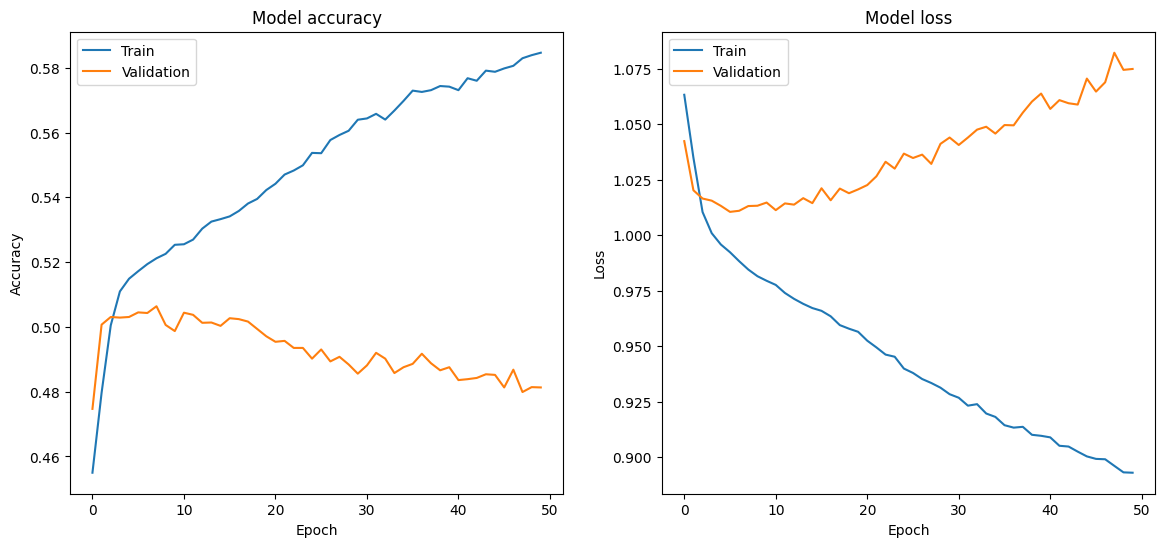

In [152]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [154]:
'Chelsea' in data['home_team_name'].unique()

False

In [155]:
data['home_team_name'].unique()

array([743,  55, 109, 838, 238, 190, 474,  47, 158, 464, 770, 463, 274,
       580,  98, 840, 612, 509,  99, 432, 591, 570, 354, 176, 170, 157,
       146, 100, 678, 517, 835, 745, 706, 677, 582, 516, 211, 123, 846,
       127,  82, 342, 837, 735, 335, 775, 744, 407, 800, 863, 200, 774,
       747, 712, 694, 303, 607, 500, 699, 126, 431, 270, 494,  77,  37,
       196, 331, 471, 688, 660, 486, 560, 621, 101, 520,  97,  68, 203,
       832, 633, 640, 787, 823, 760, 436, 888, 575, 386, 881, 477, 430,
       356, 527, 860, 175, 623, 223, 698, 586, 227, 461, 833, 251, 810,
       351, 868, 656, 185, 764, 456, 423, 404, 842,  14, 740, 610,  84,
       250, 536, 364, 297, 193, 125, 662, 256, 497, 684, 419, 159, 337,
       229, 724, 253, 501, 891, 265, 426, 749, 701, 472, 692, 367, 766,
         9,  71,  69, 679, 702, 204, 559, 730, 465, 752,  27, 375, 294,
       104, 240, 697, 618, 626,  79, 562, 589, 312, 279, 598, 202, 280,
       751, 381, 313, 180, 457, 779, 244, 246, 408, 797, 875, 36

In [153]:
# Assuming `label_encoder` and `model` are already defined from the training process

def preprocess_input(home_team, away_team, home_form, away_form):
    home_team_encoded = label_encoder.transform([home_team])
    away_team_encoded = label_encoder.transform([away_team])
    
    home_form_array = np.array([home_form])
    away_form_array = np.array([away_form])
    
    return home_form_array, away_form_array, home_team_encoded, away_team_encoded

def predict_match(home_team, away_team, home_form, away_form):
    home_form_array, away_form_array, home_team_encoded, away_team_encoded = preprocess_input(home_team, away_team, home_form, away_form)
    
    prediction = model.predict([home_form_array, away_form_array, home_team_encoded, away_team_encoded])
    predicted_class = np.argmax(prediction, axis=1)
    
    return predicted_class[0]

# Example usage
home_team = 'Chelsea'
away_team = 'TeamB'
home_form = [1, 0, 1, 1, 0]  # Example recent form
away_form = [0, 1, 0, 0, 1]  # Example recent form

result = predict_match(home_team, away_team, home_form, away_form)
print(f'Predicted result: {result}')  # 0: Home win, 1: Draw, 2: Away win

ValueError: y contains previously unseen labels: 'TeamA'